In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math
import re
from collections import defaultdict
from itertools import combinations
import networkx as nx
import community
from utils.cluster import cluster
from utils.recombinations import recombinations
from matplotlib.colors import LogNorm, LinearSegmentedColormap
from pandas.io.formats.style import Styler
from utils.preprocessing import preprocessing
import os
import seaborn as sns
import igraph as ig
import scipy.stats as stats
import mplcursors
import plotly.express as px
import plotly.graph_objs as go
import plotly.io as pio
from Bio.PDB import PDBParser, Selection, NeighborSearch
from numpy import linalg as LA
from Bio.SeqUtils import seq1
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord
from Bio.SeqUtils import nt_search
from Bio.Seq import MutableSeq
from Bio import motifs
import statannot

import logomaker
cdrpos = {
# http://www.bioinf.org.uk/abs/info.html#cdrid
# light chain loop positions (chothia)
    'L': {
    'L1' : ['26', '32'],
    'L2' : ['50', '52'],
    'L3' : ['91', '96'],
    },
# heavy chain loop positions (chothia)
    'H': {
    'H1' : ['26', '32'],
    'H2' : ['52', '56'],
    'H3' : ['96', '101']
    }
}

In [2]:
sjogren_path = '../Data/new_sjogren_file/'
healthy_path = '../Data/in_house_healthy/'

In [3]:
def vj_gene_usage(dataframe, index):
    j_counts = dataframe.groupby('v_call')['j_call'].apply(lambda x: (x.unique(), x.value_counts()))
    v_genes = j_counts.index.to_list()
    j_genes = j_counts.apply(lambda x: x[0]).to_list()
    counts = j_counts.apply(lambda x: x[1].to_list()).to_list()

    vj_gene_usage = {}
    for i, v_gene in enumerate(v_genes):
        vj_gene_usage_dict = {jgene: count for jgene, count in zip(j_genes[i], counts[i])}
        vj_gene_usage[v_gene] = vj_gene_usage_dict

    df = pd.DataFrame.from_dict(vj_gene_usage, orient='index')
    df = df.reindex(sorted(df.columns), axis=1)
    df = df.reindex(sorted(index), axis=0)
    #df = df.fillna(0)
    df_normalized = df.div(df.sum(axis=1).sum())

    return df_normalized

def v_gene_usage(dataframe, index):
    counts = dataframe['v_call'].value_counts()
    counts = counts.reindex(sorted(index), axis=0)
    counts.fillna(0, inplace=True)
    counts = counts.div(counts.sum())
    counts.replace(0, 0.0001, inplace=True)
    return counts

def shared_diff_vj_genes(path, threshold):
    vj_genes = defaultdict(list)

    for file in os.listdir(path):
        df = pd.read_csv(os.path.join(path, file), sep='\t')
        dataframe = preprocessing(df)
        index = dataframe()['v_call'].unique()

        df_naive = vj_gene_usage(dataframe.get_naive(), index)
        df_mature = vj_gene_usage(dataframe.get_mature(), index)

        df_naive.replace(0, 0.0001, inplace=True)
        df_mature.replace(0, 0.0001, inplace=True)

        df_naive = df_naive.div(df_naive.sum(axis=1).sum())
        df_mature = df_mature.div(df_mature.sum(axis=1).sum())

        df_change = df_mature - df_naive

        for row in df_change.iterrows():
            for col in df_change.columns:
                if  row[1][col] > threshold:
                    vj_genes[file].append([row[0], col])

    shared_genes = defaultdict(int)
    for patient, gene in vj_genes.items():
        for gene_pair in gene:
            str_gene_pair = gene_pair[0] + '|' + gene_pair[1]
            if str_gene_pair not in shared_genes.keys():
                shared_genes[str_gene_pair] = 1
            else:
                shared_genes[str_gene_pair] += 1
    return shared_genes

def shared_diff_v_genes(path):
    v_genes = defaultdict(list)

    for file in os.listdir(path):
        dataframe = preprocessing(pd.read_csv(os.path.join(path, file), sep='\t'))
        index = dataframe()['v_call'].unique()

        df_naive = v_gene_usage(dataframe.get_naive(), index)
        df_mature = v_gene_usage(dataframe.get_mature(), index)

        df_naive = np.log2(df_naive)
        df_mature = np.log2(df_mature)

        df_change = df_mature - df_naive

        for i, row in df_change.items():
            v_genes[file].append([i, row])

    shared_genes = defaultdict(list)
    for patient, gene_count in v_genes.items():
        for v_call in gene_count:
            shared_genes[v_call[0]].append(v_call[1])
    return shared_genes

def multiple_shared_diff_genes(dict, threshold):
    output_dict = defaultdict(int)
    for gene, degree in dict.items():
        if degree > threshold:
            output_dict[gene] = degree
    return output_dict

def multiple_shared_v_genes(dict, threshold):
    output_dict = defaultdict(list)
    for gene, fc in dict.items():
        if len(fc) > threshold:
            output_dict[gene] = fc
    return output_dict

def adjust_labels(x, y, labels, min_distance=0.2):
        adjusted_labels = []
        for i in range(len(x)):
            label = labels[i]
            adjusted_x, adjusted_y = x[i], y[i]
            for j in range(i):
                if abs(adjusted_x - x[j]) < min_distance and abs(adjusted_y - y[j]) < min_distance:
                    adjusted_y += min_distance  # Adjust the y-coordinate
            adjusted_labels.append((adjusted_x, adjusted_y, label))
        return adjusted_labels

def draw_volcano_plot_pair(dataframe):
    FoldChange = defaultdict(list)
    for keys, items in dataframe.items():
        for key, item in  items.items():
            FoldChange[key].append(item)

    null_mean = 0.0
    p_values = {}

    for vj_pair, fold_changes in FoldChange.items():
        if np.var(fold_changes) == 0:
            p_value = 1.0
        else:
            t_stat, p_value = stats.ttest_1samp(fold_changes, null_mean)
        p_values[vj_pair] = p_value

    volcano_plot = pd.DataFrame()
    FC_dataframe = pd.DataFrame.from_dict(FoldChange, orient='index')
    volcano_plot['mean'] = FC_dataframe.mean(axis=1)
    volcano_plot['p-value'] = p_values.values()
    volcano_plot['std'] = FC_dataframe.std(axis=1)
    volcano_plot['-log10(p-value)'] = -np.log10(volcano_plot['p-value'])

    volcano_plot.dropna(inplace=True)
    df = volcano_plot.copy()
    significance_threshold = 0.05
    threshold_2 = 0.01
    threshold_3 = 0.001

    plt.figure(figsize=(10, 6))
    plt.scatter(df['mean'], df['-log10(p-value)'].apply(lambda x: (x if x > 0 else 0)), c='b', alpha=0.5)

    # Highlight significant points
    significant_points = df[df['p-value'] < significance_threshold]
    significant_points_1 = df[df['p-value'] < threshold_2]
    significant_points_2 = df[df['p-value'] < threshold_3]
    plt.scatter(significant_points['mean'], significant_points['-log10(p-value)'].apply(lambda x: (x if x > 0 else 0)), c='r', marker='o', label='Significant')

    # Add labels and title
    plt.xlabel('log2(Fold Change)')
    plt.ylabel('-log10(P-Value)')
    plt.title('Fold Change for Unique VJ Pair')

    # Add significance threshold line
    plt.axhline(-np.log10(significance_threshold), color='g', linestyle='--', label='p = 0.05')
    plt.axhline(-np.log10(threshold_2), color='b', linestyle='--', label='p = 0.01')
    plt.axhline(-np.log10(threshold_3), color='r', linestyle='--', label='p = 0.001')

    # Add VJ_pair labels
    for i, row in significant_points_2.iterrows():
        plt.annotate(row.name[0] + '|' + row.name[1], (row['mean'], row['-log10(p-value)']))

    plt.legend()
    plt.show()

def draw_volcano_plot(dataframe):
    FoldChange = defaultdict(list)
    for keys, items in dataframe.items():
        for key, item in  items.items():
            FoldChange[key].append(item)

    null_mean = 0.0
    p_values = {}

    for vj_pair, fold_changes in FoldChange.items():
        if np.var(fold_changes) == 0:
            p_value = 1.0
        else:
            t_stat, p_value = stats.ttest_1samp(fold_changes, null_mean)
        p_values[vj_pair] = p_value

    volcano_plot = pd.DataFrame()
    FC_dataframe = pd.DataFrame.from_dict(FoldChange, orient='index')
    volcano_plot['mean'] = FC_dataframe.mean(axis=1)
    volcano_plot['p-value'] = p_values.values()
    volcano_plot['std'] = FC_dataframe.std(axis=1)
    volcano_plot['-log10(p-value)'] = -np.log10(volcano_plot['p-value'])

    volcano_plot.dropna(inplace=True)
    df = volcano_plot.copy()
    significance_threshold = 0.05
    threshold_2 = 0.01
    threshold_3 = 0.001

    plt.figure(figsize=(10, 6))
    plt.scatter(df['mean'], df['-log10(p-value)'].apply(lambda x: (x if x > 0 else 0)), c='b', alpha=0.2)

    # Highlight significant points
    significant_points = df[df['p-value'] < significance_threshold]
    significant_points_1 = df[df['p-value'] < threshold_2]
    significant_points_2 = df[df['p-value'] < threshold_3]
    plt.scatter(significant_points['mean'], significant_points['-log10(p-value)'].apply(lambda x: (x if x > 0 else 0)), c='r', marker='o', label='Significant', alpha = 0.2)

    # Add labels and title
    plt.xlabel('log2(Fold Change)')
    plt.ylabel('-log10(P-Value)')
    plt.title('Fold Change for V genes')

    # Add significance threshold line
    plt.axhline(-np.log10(significance_threshold), color='g', linestyle='--', label='p = 0.05')
    plt.axhline(-np.log10(threshold_2), color='b', linestyle='--', label='p = 0.01')
    plt.axhline(-np.log10(threshold_3), color='r', linestyle='--', label='p = 0.001')

    labels = df.index
    adjusted_labels = adjust_labels(df['mean'], df['-log10(p-value)'], labels)

    # Add adjusted labels to the plot
    for adjusted_x, adjusted_y, label in adjusted_labels:
        plt.annotate(label.split('V')[1], (adjusted_x, adjusted_y), textcoords="offset points", xytext=(0, 5), ha='center', fontsize=5)

    plt.legend()

def interactive_volcano_plot(df):
    significance_threshold = 0.05
    df['vj_pair'] = df.index

    # Highlight significant points
    significant_points = df[df['p-value'] < significance_threshold]

    fig = px.scatter(
    significant_points,
    x='mean',
    y='-log10(p-value)',
    hover_data=['vj_pair', 'p-value', 'std'],
    labels={'-log10(p-value)': '-log10(p-value)'},
    title='Fold Change (naive : mature)',
    )

# Add significance threshold line
    fig.add_shape(
        go.layout.Shape(
            type='line',
            x0=df['mean'].min(),
            x1=df['mean'].max(),
            y0=-np.log10(significance_threshold),
            y1=-np.log10(significance_threshold),
            line=dict(color='green', dash='dash'),
        )
    )
    #pio.write_html(fig, file='volcano_plot_healthy_interactive.html')
    fig.show()

def filter_data(data):
    filtered_data = defaultdict(list)
    for gene, values in data.items():
        if len(values) > 2:
            min_value = min(values)
            max_value = max(values)
            filtered_values = [x for x in values if x != min_value and x != max_value]
            filtered_data[gene] = filtered_values
    return filtered_data

def checkCDRpos(respos, chain):
    for cdr, pos in cdrpos[chain].items():
        if compare_strings(pos[0], respos) & compare_strings(respos, pos[1]):
            return True, cdr
    return False, None

def inVgene(respos):
    if compare_strings(respos, '113'):
        return True
    return False

def compare_strings(str1, str2):
    # Extract numerical values from the input strings using regular expressions
    num1 = int(re.search(r'\d+', str1).group())
    num2 = int(re.search(r'\d+', str2).group())

    # If the numerical values are equal, compare the remaining parts of the strings
    if num1 == num2:
        alpha1 = re.search(r'[A-Za-z]+', str1).group() if re.search(r'[A-Za-z]+', str1) else ""
        alpha2 = re.search(r'[A-Za-z]+', str2).group() if re.search(r'[A-Za-z]+', str2) else ""

        # Compare the alphabetic parts using string comparison
        return alpha1 <= alpha2

    # Compare the numerical values
    return num1 <= num2

def custom_sort(strings):
    def extract_key(s):
        # Split the string into numeric and non-numeric parts
        parts = re.split(r'(\d+)', s)

        # Convert numeric parts to integers, leave non-numeric parts as they are
        converted_parts = [int(part) if part.isdigit() else part for part in parts]

        return converted_parts

    return sorted(strings, key=extract_key)

def concat_usage(path):
    data = defaultdict(pd.DataFrame)
    for file in os.listdir(path):
        df = preprocessing(pd.read_csv(os.path.join(path, file), sep='\t'))
        v, _, _ = df.get_mature_usage()
        v1, _, _ = df.get_naive_usage()
        mature_data = v.div(v.sum())
        naive_data = v1.div(v1.sum())
        # Combine the data into a single DataFrame
        df = pd.DataFrame({'Naive Repertoire': naive_data, 'Mature Repertoire': mature_data})
        data[file.split('_')[0]] = df
    dataframes = []
    for patient, repertoires in data.items():
        dataframes.append(repertoires)
    combined_df = pd.concat(dataframes)
    return combined_df


In [330]:
df = pd.read_csv('../Data/skempi_v2.tsv', sep='\t')
df

,#Pdb,Mutation(s)_PDB,Mutation(s)_cleaned,iMutation_Location(s),Hold_out_type,Hold_out_proteins,Affinity_mut (M),Affinity_mut_parsed,Affinity_wt (M),Affinity_wt_parsed,...,koff_mut_parsed,koff_wt (s^(-1)),koff_wt_parsed,dH_mut (kcal mol^(-1)),dH_wt (kcal mol^(-1)),dS_mut (cal mol^(-1) K^(-1)),dS_wt (cal mol^(-1) K^(-1)),Notes,Method,SKEMPI version
0,1CSE_E_I,LI45G,LI38G,COR,Pr/PI,Pr/PI,5.26E-11,5.260000e-11,1.12E-12,1.120000e-12,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,IASP,1
1,1CSE_E_I,LI45S,LI38S,COR,Pr/PI,Pr/PI,8.33E-12,8.330000e-12,1.12E-12,1.120000e-12,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,IASP,1
2,1CSE_E_I,LI45P,LI38P,COR,Pr/PI,Pr/PI,1.02E-07,1.020000e-07,1.12E-12,1.120000e-12,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,IASP,1
3,1CSE_E_I,LI45I,LI38I,COR,Pr/PI,Pr/PI,1.72E-10,1.720000e-10,1.12E-12,1.120000e-12,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,IASP,1
4,1CSE_E_I,LI45D,LI38D,COR,Pr/PI,Pr/PI,1.92E-09,1.920000e-09,1.12E-12,1.120000e-12,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,IASP,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7080,3QIB_ABP_CD,KP9R,KP8R,COR,TCR/pMHC,"TCR/pMHC,1JCK_A_B",2.4E-04,2.400000e-04,5.5E-06,5.500000e-06,...,0.500,2.2E-02,0.022,NaN,NaN,NaN,NaN,NaN,SPR,2
7081,3QIB_ABP_CD,TP12A,TP11A,COR,TCR/pMHC,"TCR/pMHC,1JCK_A_B",>1.1E-03,1.100000e-03,5.5E-06,5.500000e-06,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,SPR,2
7082,3QIB_ABP_CD,TP12S,TP11S,COR,TCR/pMHC,"TCR/pMHC,1JCK_A_B",3.38E-05,3.380000e-05,5.5E-06,5.500000e-06,...,0.134,2.2E-02,0.022,NaN,NaN,NaN,NaN,NaN,SPR,2
7083,3QIB_ABP_CD,TP12N,TP11N,COR,TCR/pMHC,"TCR/pMHC,1JCK_A_B",4.34E-05,4.340000e-05,5.5E-06,5.500000e-06,...,0.175,2.2E-02,0.022,NaN,NaN,NaN,NaN,NaN,SPR,2


In [72]:
# FoldChange_sjogren = defaultdict(dict)
# FoldChange_healthy = defaultdict(dict)
#
# for file in os.listdir(sjogren_path):
#     df = preprocessing(pd.read_csv(os.path.join(sjogren_path, file), sep='\t'))
#     index = df()['v_call'].unique()
#     mature = v_gene_usage(df.get_mature(), index)
#     naive = v_gene_usage(df.get_naive(), index)
#     FC = np.log2(mature/naive)
#     FC_dict = {}
#     for i, row in FC.items():
#         if pd.notna(row):
#             FC_dict[i] = row
#     FoldChange_sjogren[file.split('_')[0]] = FC_dict
#
# for file in os.listdir(healthy_path):
#     df = preprocessing(pd.read_csv(os.path.join(healthy_path, file), sep='\t'))
#     index = df()['v_call'].unique()
#     mature = v_gene_usage(df.get_mature(), index)
#     naive = v_gene_usage(df.get_naive(), index)
#     FC = np.log2(mature/naive)
#     FC_dict = {}
#     for i, row in FC.items():
#         if pd.notna(row):
#             FC_dict[i] = row
#     FoldChange_healthy[file.split('_')[0]] = FC_dict
sjogren_multiple_shared = multiple_shared_v_genes(shared_diff_v_genes(sjogren_path), 4)
healthy_multiple_shared = multiple_shared_v_genes(shared_diff_v_genes(healthy_path), 1)

common_vgenes = set(sjogren_multiple_shared.keys()).intersection(healthy_multiple_shared.keys())

sjogren_data = defaultdict(list)
healthy_data = defaultdict(list)

for v_gene in common_vgenes:
    sjogren_data[v_gene] = sjogren_multiple_shared[v_gene]
    healthy_data[v_gene] = healthy_multiple_shared[v_gene]

sjogren_data = dict(sorted(sjogren_data.items()))
healthy_data = dict(sorted(healthy_data.items()))

max_sjogren = 0
max_healthy = 0
for key, items in sjogren_data.items():
    if max_sjogren < len(items):
        max_sjogren = len(items)
for key, items in healthy_data.items():
    if max_healthy < len(items):
        max_healthy = len(items)

for key, items in sjogren_data.items():
    sjogren_data[key].extend([np.nan]*(max_sjogren-len(items)))
for key, items in healthy_data.items():
    healthy_data[key].extend([np.nan]*(max_healthy-len(items)))


In [322]:
diff_df = pd.DataFrame.from_dict({'Sjogren': sjogren_data, 'Healthy': healthy_data})
diff_df.rename_axis(inplace=True)
genes = diff_df.index
diff_df = diff_df.T.explode(list(genes))
diff_df.reset_index(drop=False, inplace=True)
diff_df_melted = pd.melt(diff_df[['index', 'IGHV1-18', 'IGHV1-24','IGHV1-69', 'IGHV2-26', 'IGHV3-23','IGHV3-30-3', 'IGHV3-43','IGHV3-53', 'IGHV3-72', 'IGHV4-34', 'IGHV5-51', 'IGHV6-1']], id_vars=['index'], var_name='V Genes', value_name='Value')
diff_df_melted.columns = ['Group', 'V Genes', 'Log Fold Change']
diff_df_melted.dropna(inplace=True)
diff_df_melted['Log Fold Change'] = pd.to_numeric(diff_df_melted['Log Fold Change'], errors='raise')

In [128]:
diff_df

,index,IGHV1-18,IGHV1-2,IGHV1-24,IGHV1-3,IGHV1-45,IGHV1-46,IGHV1-58,IGHV1-69,IGHV1-8,...,IGHV4-34,IGHV4-38-2,IGHV4-39,IGHV4-4,IGHV4-59,IGHV4-61,IGHV5-10-1,IGHV5-51,IGHV6-1,IGHV7-4-1
0,Sjogren,-0.333849,-0.100255,-1.376596,-0.251679,-1.448462,-1.03194,-2.218182,-1.176509,-1.104888,...,0.677622,5.043391,-0.150407,-0.126892,-0.283914,0.046136,4.617463,-0.011134,0.118702,-0.729906
1,Sjogren,-0.289484,-0.316182,1.052802,-0.287986,0.813101,-0.553222,-0.91935,-0.51944,-0.947696,...,-1.228859,3.550066,0.049689,3.93301,-0.216755,0.551898,0.276153,-0.112123,-0.475934,0.46747
2,Sjogren,-0.307403,-0.143826,-1.198793,0.315902,3.443201,0.038994,-0.162621,-1.225048,0.061652,...,-1.149718,4.858238,-0.031171,0.386238,-0.082384,5.816659,3.358087,-0.353648,0.215729,1.198394
3,Sjogren,-0.304564,-0.394747,-1.862563,0.238904,0.63449,-0.492557,-0.248413,-0.766271,-0.81741,...,-1.892408,0.156355,-0.216903,0.015726,-0.221727,0.332019,-1.316057,-0.112966,0.724949,-1.759174
4,Sjogren,-0.3045,1.74972,-1.779946,-0.161224,-0.856926,-0.417937,-0.161986,-1.21383,-0.640233,...,-1.140998,0.186456,-0.075476,-0.127363,0.214682,0.297026,-0.70178,-0.152671,0.870735,0.050317
5,Sjogren,0.173676,-0.866118,-2.22943,-0.235232,-1.397477,-0.500935,-1.451201,-1.526726,-2.156745,...,-2.336924,-1.330641,-0.61683,-0.312003,0.138135,0.987874,-1.096034,-1.116602,-0.734885,-2.82401
6,Sjogren,-0.668795,-0.589539,-1.224782,-0.180501,0.461719,-0.302741,-1.538281,-1.731223,-0.499649,...,-2.136896,0.25951,-0.253762,-0.246678,0.136373,0.4415,-0.932416,-0.532013,0.715005,-2.123244
7,Sjogren,-0.712642,-0.384734,-1.9244,0.090631,-1.0269,-0.318116,-1.614983,-1.446363,0.082435,...,-1.790669,0.008143,-0.398881,0.014846,-0.061894,4.027579,-0.343739,-0.865288,1.033721,-0.628413
8,Sjogren,-0.658309,-0.66792,-1.022325,-0.378505,2.190213,-0.453657,-1.695103,-1.377062,2.054656,...,-2.042214,0.167979,-0.100851,-0.424861,-0.151383,-0.482001,0.350889,-0.393452,1.267338,-0.762637
9,Sjogren,-0.379004,-0.43255,-1.188139,-0.129143,-0.55722,-0.486448,-0.786402,-1.402327,1.987101,...,-1.756354,4.209493,0.156375,0.294665,0.126044,0.100667,5.186334,-0.000136,0.276306,-0.536461


p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

IGHV4-34_Sjogren v.s. IGHV4-34_Healthy: t-test independent samples with Bonferroni correction, P_val=1.000e+00 stat=-8.786e-01
IGHV5-51_Sjogren v.s. IGHV5-51_Healthy: t-test independent samples with Bonferroni correction, P_val=6.324e-02 stat=-3.017e+00
IGHV6-1_Sjogren v.s. IGHV6-1_Healthy: t-test independent samples with Bonferroni correction, P_val=8.983e-03 stat=-3.768e+00
IGHV3-72_Sjogren v.s. IGHV3-72_Healthy: t-test independent samples with Bonferroni correction, P_val=1.280e-01 stat=-2.730e+00
IGHV1-24_Sjogren v.s. IGHV1-24_Healthy: t-test independent samples with Bonferroni correction, P_val=2.617e-01 stat=2.424e+00
IGHV1-18_Sjogren v.s. IGHV1-18_Healthy: t-test independent samples with Bonferroni correction, P_val=8.568e-01 stat=1.871e+00
IGHV1-69_Sjogren v.s. IGHV1-69_Healthy: t-test independent samples with Bonfer

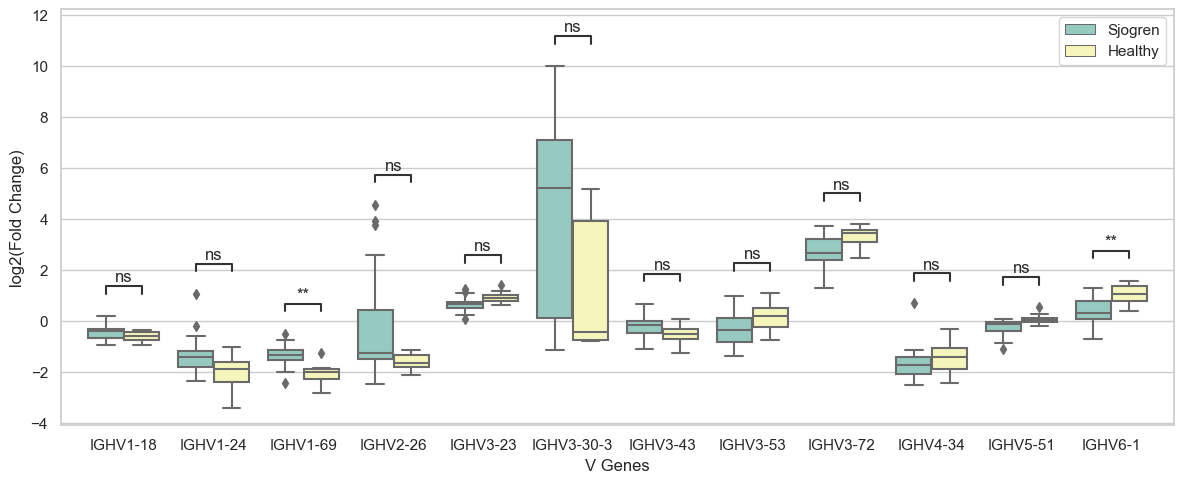

In [324]:
# Create a boxplot using Seaborn
plt.figure(figsize=(12, 5))
sns.set(style="whitegrid")  # Optional styling
ax = sns.boxplot(data=diff_df_melted, x='V Genes', y='Log Fold Change',hue='Group', palette='Set3')
plt.xlabel("V Genes")
plt.ylabel("log2(Fold Change)")

box_pairs = []
variables = diff_df_melted['V Genes'].unique()
groups = diff_df_melted['Group'].unique()

for var in variables:
    box_pairs.append(((var, groups[0]), (var, groups[1])))

# Add statistical significance annotations
statannot.add_stat_annotation(ax, data=diff_df_melted, box_pairs=box_pairs, x='V Genes', y='Log Fold Change', hue='Group', test='t-test_ind', loc='inside', text_format='star', verbose=2)

# plt.setp(ax.xaxis.get_majorticklabels(), rotation=-45, ha="left" )
sns.move_legend(
    ax, "upper right", ncol=1, title=None, frameon=True
)

plt.tight_layout()
# plt.savefig('../Data/Figures/V_gene_expansion_t-test.png', dpi=500)


In [272]:
paths = [sjogren_path, healthy_path]
df_paths = []

for path in paths:
    files = os.listdir(path)
    series_list = []

    for file in files:
        df = preprocessing(pd.read_csv(os.path.join(path, file), sep='\t'))()
        series_list.append(df.groupby('v_call')['cdr3_aa'].apply(lambda x: x.apply(lambda x: len(x))))

    temp = pd.DataFrame(pd.concat(series_list, axis=0)).reset_index()
    temp = temp[['v_call', 'cdr3_aa']]

    df_paths.append(temp)

df_paths[0].reset_index(drop=False, inplace=True)
df_paths[0]['index'] = ['Sjogren']*len(df_paths[0])
df_paths[1].reset_index(drop=False, inplace=True)
df_paths[1]['index'] = ['Healthy']*len(df_paths[1])

merged_df = pd.concat(df_paths, axis=0)
merged_df.columns = ['Group', 'V Genes', 'CDR3 Length']

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

IGHV4-30-2_Sjogren v.s. IGHV4-30-2_Healthy: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=5.012e-04 U_stat=2.116e+07
IGHV1-69_Sjogren v.s. IGHV1-69_Healthy: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=0.000e+00 U_stat=7.948e+09
IGHV1-45_Sjogren v.s. IGHV1-45_Healthy: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=7.178e+04
IGHV2-26_Sjogren v.s. IGHV2-26_Healthy: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.734e-103 U_stat=7.819e+07
IGHV3-43D_Sjogren v.s. IGHV3-43D_Healthy: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=5.350e-02 U_stat=5.394e+06
IGHV3-72_Sjogren v.s. IGHV3-72_Healthy: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=3.602e+07
I

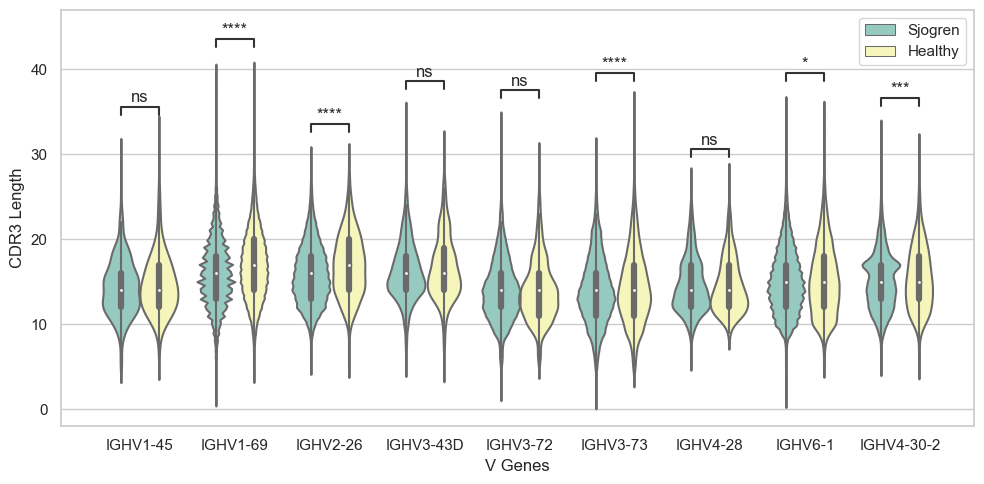

In [312]:
# Create a violin plot with significance marking
plt.figure(figsize=(10, 5))

data = merged_df[merged_df['V Genes'].isin(['IGHV1-69', 'IGHV3-43D', 'IGHV4-28', 'IGHV3-72', 'IGHV1-45', 'IGHV4-30-2', 'IGHV3-73', 'IGHV2-26', 'IGHV6-1'])]
# data = merged_df[~merged_df['V Genes'].isin(['IGHV2-70D'])]


# Create the violin plot for both 'Healthy' and 'Sjogren' columns
ax = sns.violinplot(data=data, x='V Genes', y='CDR3 Length', hue='Group', palette='Set3')

box_pairs = []
variables = data['V Genes'].unique()
groups = data['Group'].unique()

for var in variables:
    box_pairs.append(((var, groups[0]), (var, groups[1])))

statannot.add_stat_annotation(ax, data=data, x='V Genes', y='CDR3 Length', hue='Group', box_pairs=box_pairs, test='Mann-Whitney', text_format='star', verbose=2, loc="inside")

# plt.setp(ax.xaxis.get_majorticklabels(), rotation=-45, ha="left" )
sns.move_legend(
    ax, "upper right", ncol=1, title=None, frameon=True
)
plt.tight_layout()
plt.savefig('../Data/Figures/CDR3_length/CDR3_length_violin_sel_mann_whitney.png', dpi=500)

In [22]:
list(common_vgenes)

['IGHV3-21',
 'IGHV2-26',
 'IGHV4-59',
 'IGHV3-7',
 'IGHV1-2',
 'IGHV3-72',
 'IGHV3-33',
 'IGHV3-73',
 'IGHV7-4-1',
 'IGHV3-74',
 'IGHV3-11',
 'IGHV3-30-3',
 'IGHV4-39',
 'IGHV3-30',
 'IGHV3-43',
 'IGHV3-NL1',
 'IGHV3-66',
 'IGHV1-24',
 'IGHV3-43D',
 'IGHV3-64D',
 'IGHV4-30-4',
 'IGHV4-31',
 'IGHV3-20',
 'IGHV1-46',
 'IGHV4-28',
 'IGHV1-69',
 'IGHV3-53',
 'IGHV4-38-2',
 'IGHV1-58',
 'IGHV1-45',
 'IGHV4-30-2',
 'IGHV6-1',
 'IGHV4-4',
 'IGHV5-10-1',
 'IGHV1-18',
 'IGHV4-34',
 'IGHV3-9',
 'IGHV3-23',
 'IGHV3-48',
 'IGHV3-64',
 'IGHV3-15',
 'IGHV1-8',
 'IGHV2-5',
 'IGHV3-49',
 'IGHV3-13',
 'IGHV5-51',
 'IGHV1-3',
 'IGHV2-70',
 'IGHV4-61']

In [40]:
test_path = os.path.join(sjogren_path, 'S8_add_d_gene.tsv')
gene_list = list(common_vgenes)

for gene in gene_list:
    gini_sjogren = []
    gini_healthy = []
    for file in os.listdir(sjogren_path):
        df = preprocessing(pd.read_csv(os.path.join(sjogren_path, file), sep='\t'))()
        cl = cluster(df[df['v_call'] == gene])
        if len(df[df['v_call'] == gene]) == 0:
            continue
        _, temp = cl.clonal_expansion_index_by_duplicates()
        gini_sjogren.append(temp)
    for file in os.listdir(healthy_path):
        df = preprocessing(pd.read_csv(os.path.join(healthy_path, file), sep='\t'))()
        cl = cluster(df[df['v_call'] == gene])
        if len(df[df['v_call'] == gene]) == 0:
            continue
        _, temp = cl.clonal_expansion_index_by_duplicates()
        gini_healthy.append(temp)

    max_length = max(len(gini_sjogren), len(gini_healthy))

    if len(gini_sjogren)<max_length:
        gini_sjogren.extend([np.nan]*(max_length-len(gini_sjogren)))
    if len(gini_healthy)<max_length:
        gini_healthy.extend([np.nan]*(max_length-len(gini_healthy)))

    df_gini = pd.DataFrame({'healthy': gini_healthy, 'sjogren': gini_sjogren})

    sns.boxplot(data=df_gini, palette=['lightgrey', 'skyblue'], width=0.35)

    group1_data = df_gini['healthy'].dropna()
    group2_data = df_gini['sjogren'].dropna()
    p_value = stats.ttest_ind(group1_data, group2_data, alternative="two-sided").pvalue
    if p_value<0.001:
        plt.text(0.5, 0.7, "***", fontsize=20, color='black', ha='center', va='center')
        plt.plot([0.2, 0.8], [0.7, 0.7], color='black', linewidth=1)  # Horizontal line
        plt.plot([0.2, 0.2], [0.68, 0.7], color='black', linewidth=1)   # Vertical line
        plt.plot([0.8, 0.8], [0.68, 0.7], color='black', linewidth=1)
    elif p_value<0.01:
        plt.text(0.5, 0.7, "**", fontsize=20, color='black', ha='center', va='center')
        plt.plot([0.2, 0.8], [0.7, 0.7], color='black', linewidth=1)  # Horizontal line
        plt.plot([0.2, 0.2], [0.68, 0.7], color='black', linewidth=1)   # Vertical line
        plt.plot([0.8, 0.8], [0.68, 0.7], color='black', linewidth=1)
    elif p_value<0.05:
        plt.text(0.5, 0.7, "*", fontsize=20, color='black', ha='center', va='center')
        plt.plot([0.2, 0.8], [0.7, 0.7], color='black', linewidth=1)  # Horizontal line
        plt.plot([0.2, 0.2], [0.68, 0.7], color='black', linewidth=1)   # Vertical line
        plt.plot([0.8, 0.8], [0.68, 0.7], color='black', linewidth=1)
    # Customize the plot
    plt.ylabel('Gini Index')
    plt.title(f'Gini Index of {gene} Repertoire')
    plt.xticks([0, 1], ['Healthy Control', 'Sjogren'])
    plt.tight_layout()
    plt.savefig(f'../Data/Figures/Gini/Gini_index_duplicates_{gene}.png', dpi=500)
    plt.close()

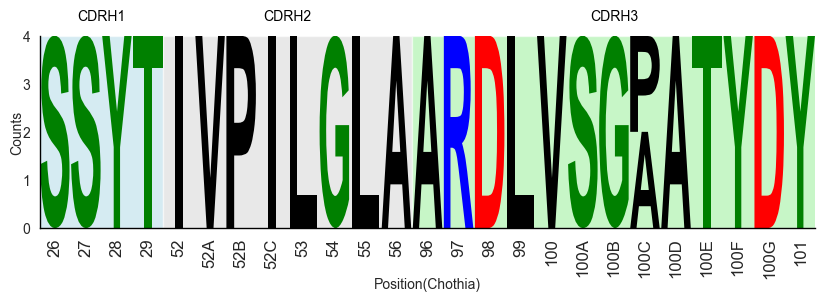

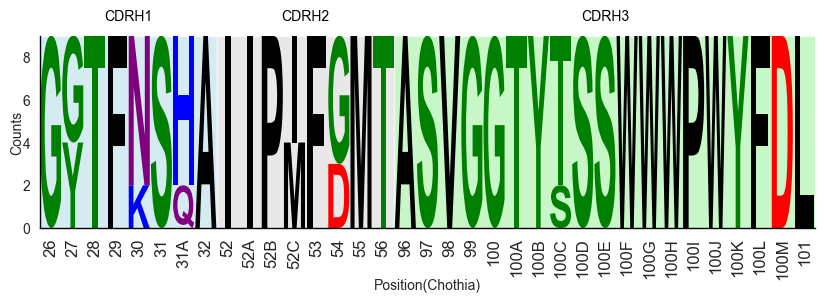

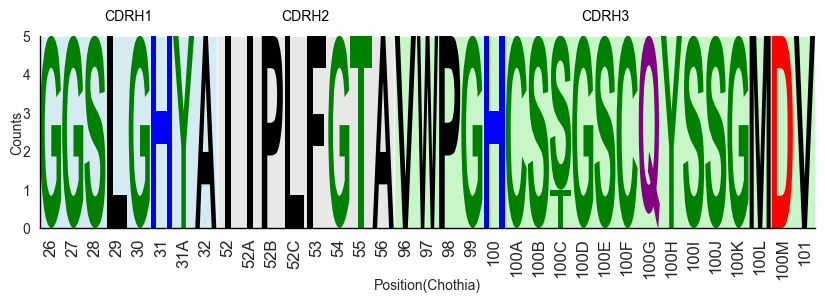

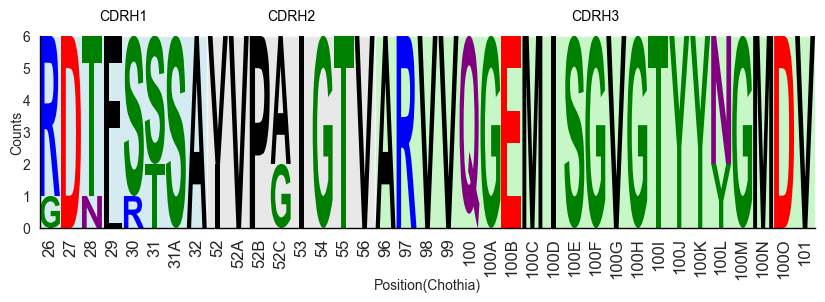

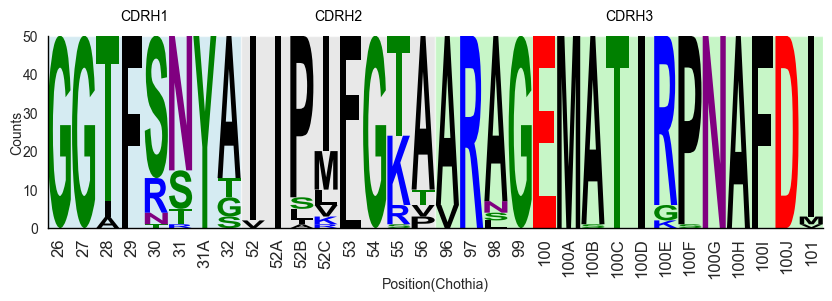

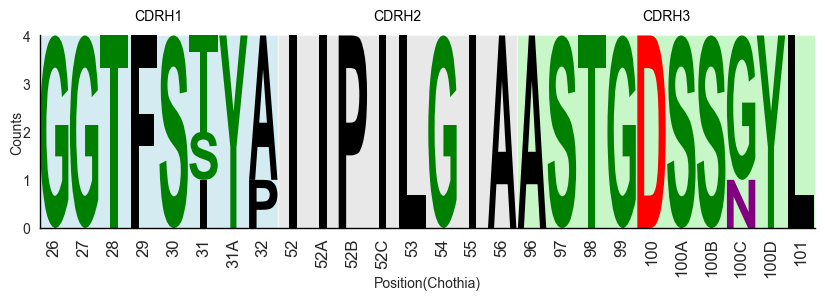

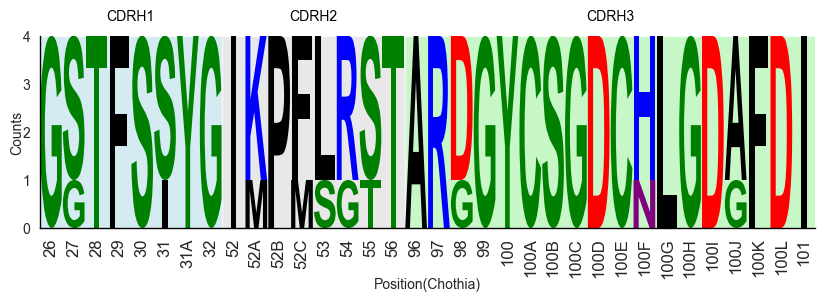

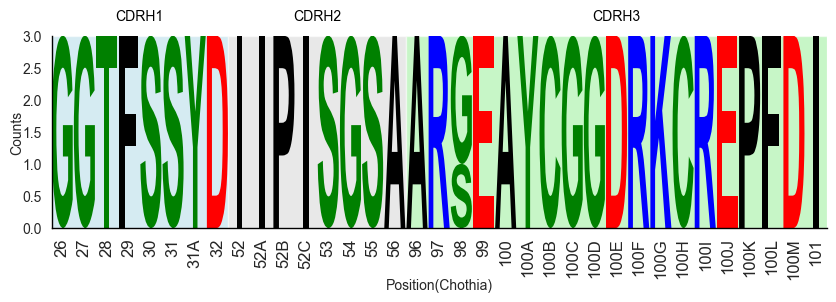

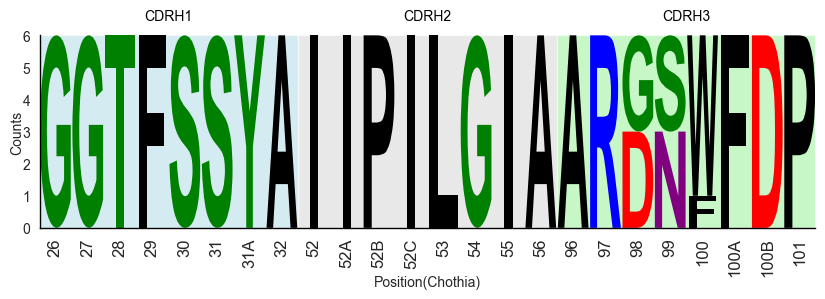

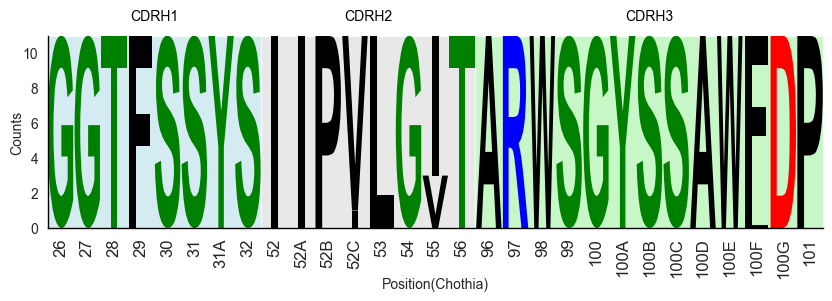

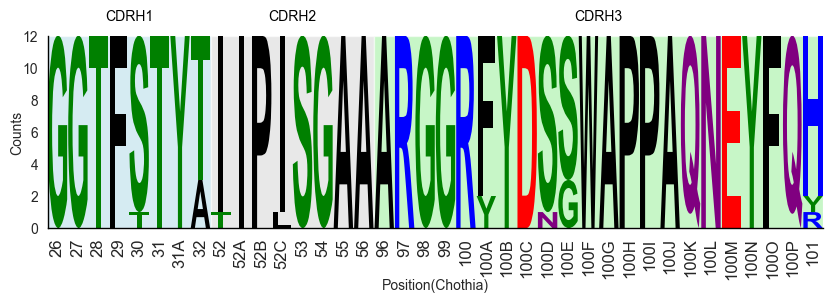

In [79]:
#seqlogo generation for individual patients, for specific v-gene repertoire

for file in os.listdir(healthy_path):
    df = preprocessing(pd.read_csv(os.path.join(healthy_path, file), sep='\t'))()
    cl = cluster(df[df['v_call'] == 'IGHV1-69'])
    g = cl.create_graph()
    # Find the connected components
    connected_components = list(nx.connected_components(g))
    # Identify the largest connected component
    largest_connected_component = max(connected_components, key=len)
    isolated_nodes = [node for node in g.nodes() if g.degree(node) == 1]
    large = sorted(connected_components, key=len, reverse=True)[:3]
    small = sorted(connected_components, key=len, reverse=False)[:5]
    counts = defaultdict(lambda: defaultdict(list))
    dataframes = []
    highlight_lengths = defaultdict(int)
    for i, cdr in enumerate(['H1', 'H2', 'H3']):
        sequences = df[df['sequence_id'].isin(large[0])][['cdr1_aa','cdr2_aa','cdr3_aa']].T.iloc[i].to_list()
        # sequences = df[df['v_call'] == 'IGHV1-69'][['cdr1_aa','cdr2_aa','cdr3_aa']].T.iloc[i].to_list()
        highlight_lengths[cdr] = 0
        for sequence in sequences:
            len_aa = len(sequence)
            len_chothia = int(cdrpos['H'][cdr][1]) - int(cdrpos['H'][cdr][0]) + 1
            if highlight_lengths[cdr] < len_aa:
                highlight_lengths[cdr] = len_aa
            duplicates = len_aa - len_chothia
            chothia_range = list(range(int(cdrpos['H'][cdr][0]), int(cdrpos['H'][cdr][1]) + 1))
            for i in range(duplicates):
                if cdr == 'H1':
                    chothia_range.append(str('31') + chr(ord('A') + i))
                if cdr == 'H2':
                    chothia_range.append(str('52') + chr(ord('A') + i))
                if cdr == 'H3':
                    chothia_range.append(str('100') + chr(ord('A') + i))
            chothia_range = [str(item) for item in chothia_range]
            chothia_range = custom_sort(chothia_range)
            for i, char in enumerate(sequence):
                counts[cdr][chothia_range[i]].append(char)

        series_data = {k: pd.Series(v) for k, v in counts[cdr].items()}
        # Convert the series to a DataFrame
        df1 = pd.DataFrame(series_data)
        df1 = df1.apply(lambda x: x.value_counts())
        dataframes.append(df1)

    df_logo = pd.concat(dataframes, axis=1)
    df_logo = df_logo.transpose()
    df_logo = df_logo.fillna(0)
    chothia_ind = custom_sort(df_logo.index)
    df_logo = df_logo.reindex(chothia_ind)
    df_logo.reset_index(drop=True, inplace=True)

    # Create the sequence logo using logomaker
    logo = logomaker.Logo(df_logo, center_values=False, color_scheme='chemistry')
    # Customize the logo
    logo.ax.grid(visible=False)
    logo.style_xticks()
    logo.style_spines(visible=False)
    logo.style_spines(spines=['left','bottom'], visible=True)
    logo.ax.set_xticks(range(len(chothia_ind)))
    logo.ax.set_xticklabels(chothia_ind, rotation=90, fontsize=12)
    logo.highlight_position_range(0, highlight_lengths['H1']-1, alpha = 0.5, color = 'lightblue')
    logo.highlight_position_range(highlight_lengths['H1'], highlight_lengths['H1'] + highlight_lengths['H2'] - 1, alpha = 0.5, color = 'lightgray')
    logo.highlight_position_range(highlight_lengths['H1'] + highlight_lengths['H2'], highlight_lengths['H1'] + highlight_lengths['H2'] + highlight_lengths['H3'] - 1, alpha = 0.5, color = 'lightgreen')
    height = df_logo.T.sum().max()
    logo.ax.text((highlight_lengths['H1']-1)/2, 1.1*height, "CDRH1", fontsize=10, color='black', ha='center', va='center')
    logo.ax.text((highlight_lengths['H1'] + highlight_lengths['H1'] + highlight_lengths['H2'] - 1)/2, 1.1*height, "CDRH2", fontsize=10, color='black', ha='center', va='center')
    logo.ax.text((highlight_lengths['H1'] + highlight_lengths['H2'] + highlight_lengths['H1'] + highlight_lengths['H2'] + highlight_lengths['H3'] - 1)/2, 1.1*height, "CDRH3", fontsize=10, color='black', ha='center', va='center')
    logo.ax.set_xlabel("Position(Chothia)", fontsize=10, va='center')
    logo.ax.set_ylabel("Counts", fontsize=10, va='center')
    #Create the sequence logo chart
    plt.savefig(os.path.join( '../Data/Figures/SeqLogo/Largest_Cluster_Healthy/' , f"{file.split('.')[0]}.png"), dpi=500, bbox_inches='tight')

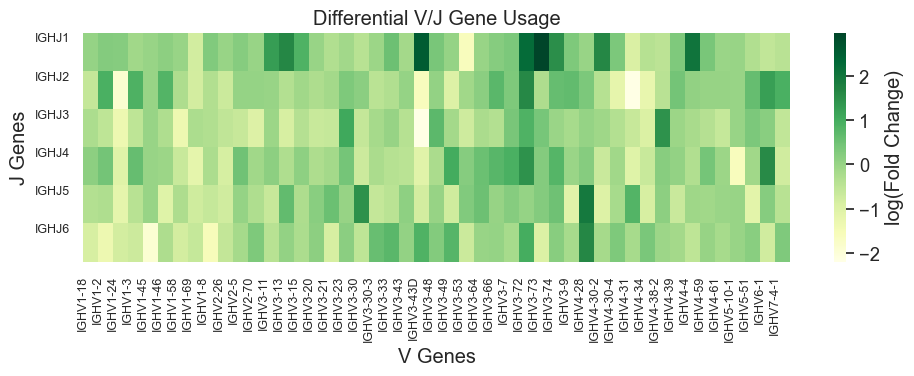

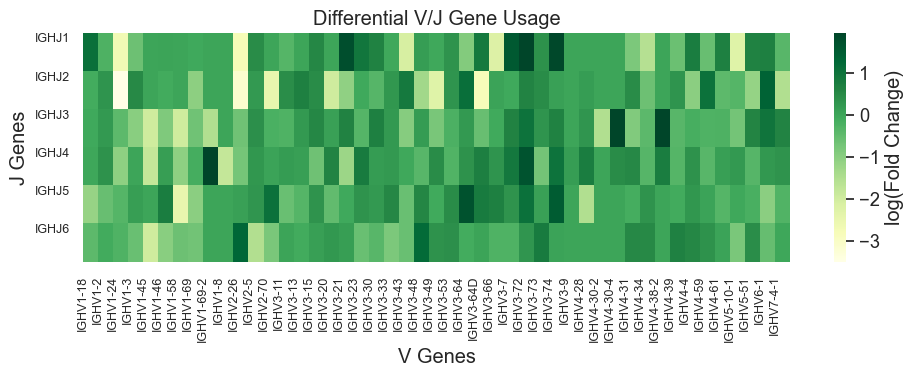

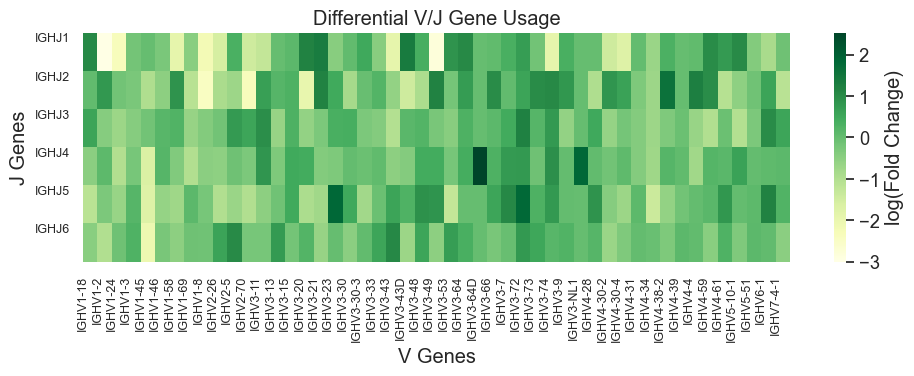

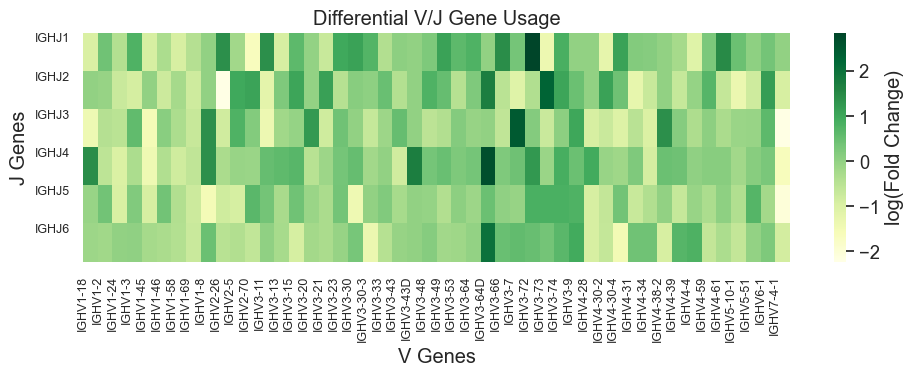

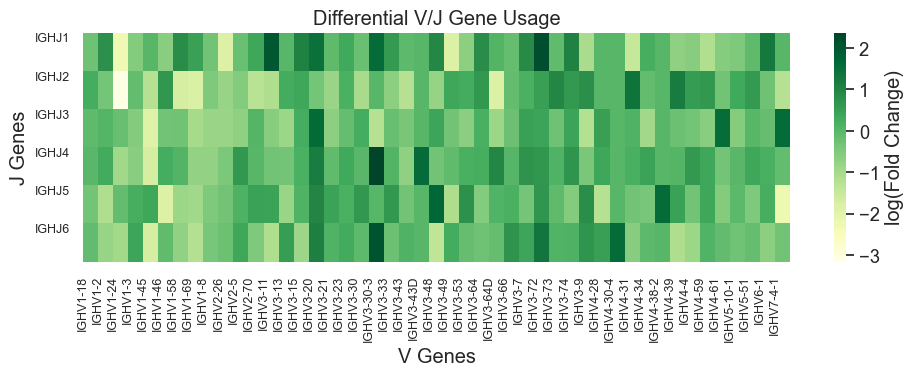

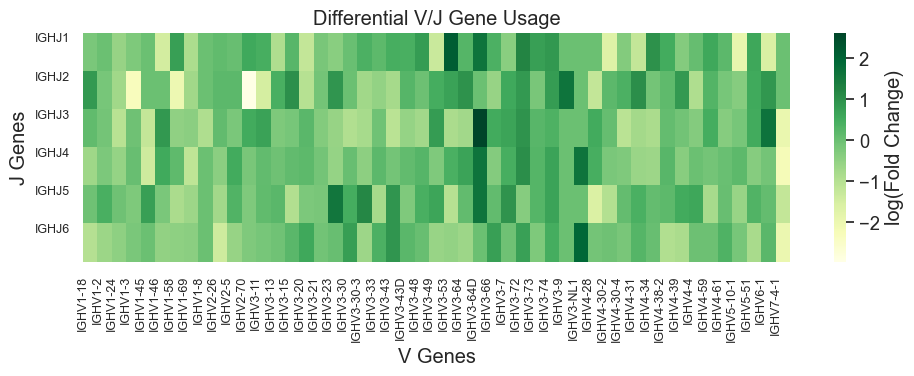

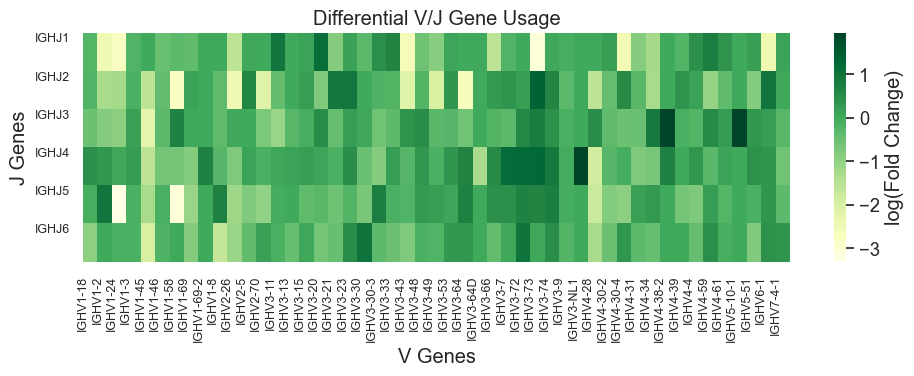

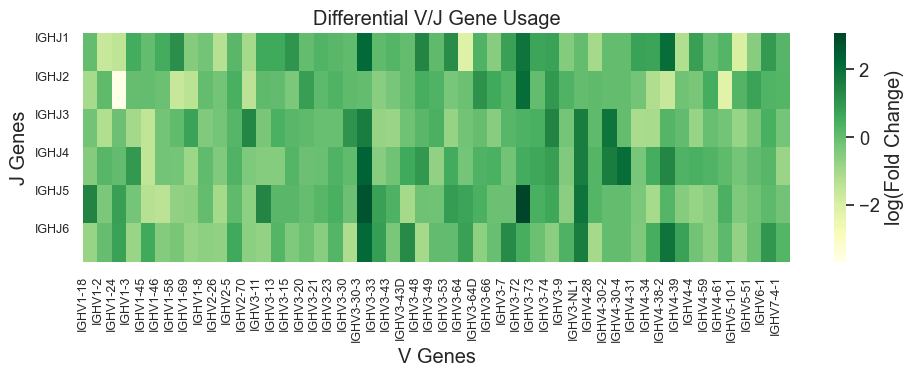

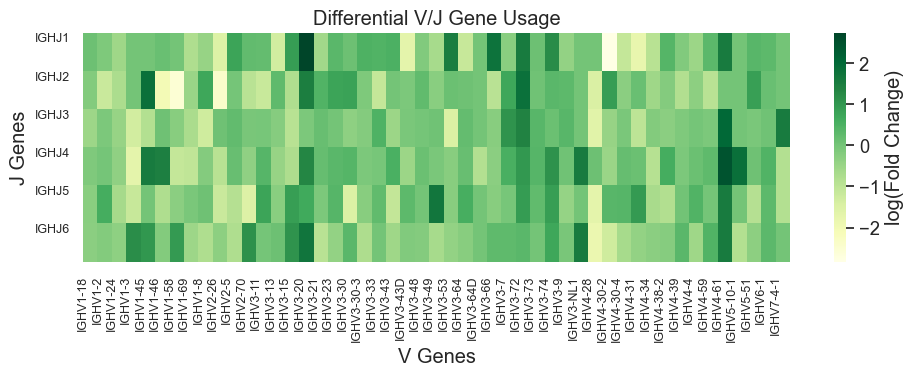

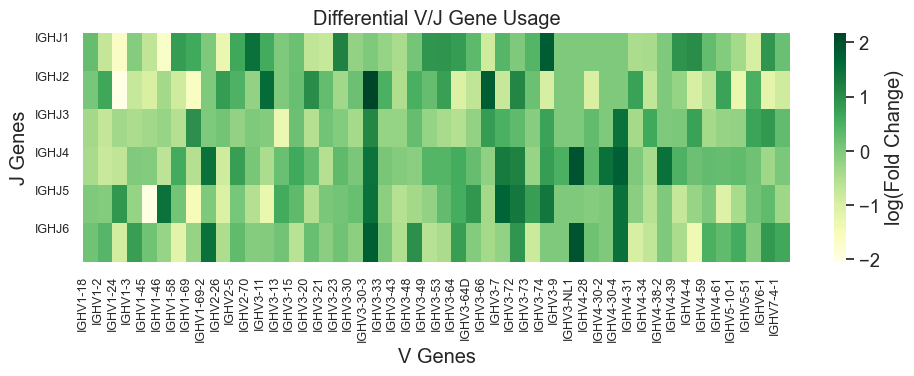

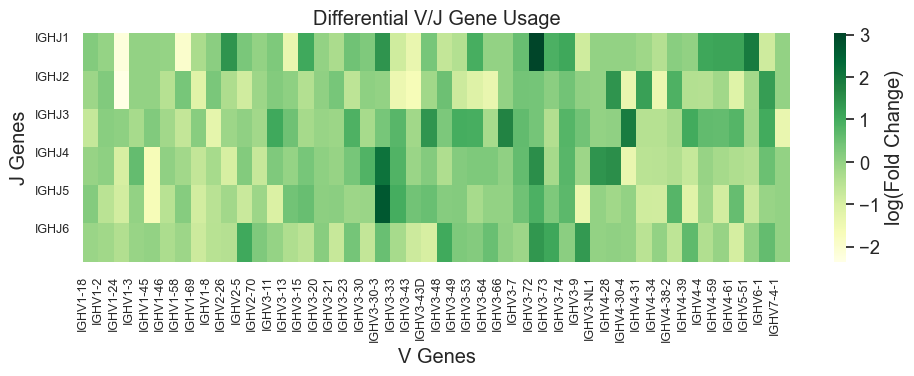

In [75]:
path =  '../Data/in_house_healthy/'
files = os.listdir(path)

for file in files:
    df = pd.read_csv(os.path.join(path, file), sep='\t')
    dataframe = preprocessing(df)
    index = dataframe()['v_call'].unique()

    df_naive = vj_gene_usage(dataframe.get_naive(), index)
    df_mature = vj_gene_usage(dataframe.get_mature(), index)

    df_naive.replace(0, 0.000001, inplace=True)
    df_naive = np.log10(df_naive)

    df_mature.replace(0, 0.000001, inplace=True)
    df_mature = np.log10(df_mature)

    df_change = df_mature - df_naive

    plt.figure(figsize=(10, 4))
    sns.set(font_scale = 1.2)
    sns.heatmap(df_change.transpose(), annot=False, cmap='YlGn', cbar_kws={'label': 'log(Fold Change)'})

    plt.title('Differential V/J Gene Usage')
    plt.xlabel('V Genes')
    plt.ylabel('J Genes', rotation=90)

    ax = plt.gca()
    ax.set_xticks(range(len(df_change.index)))
    ax.set_xticklabels(df_change.index, fontsize = 9, ha='center')

    ax.set_yticks(range(len(df_change.columns)))
    ax.set_yticklabels(df_change.columns, rotation=0, va='top', fontsize = 9)

    plt.tight_layout()
    plt.savefig(f'../Data/diff_usage_healthy/{file.split(".")[0]}_differential_v_j_gene_usage.png', dpi=500)

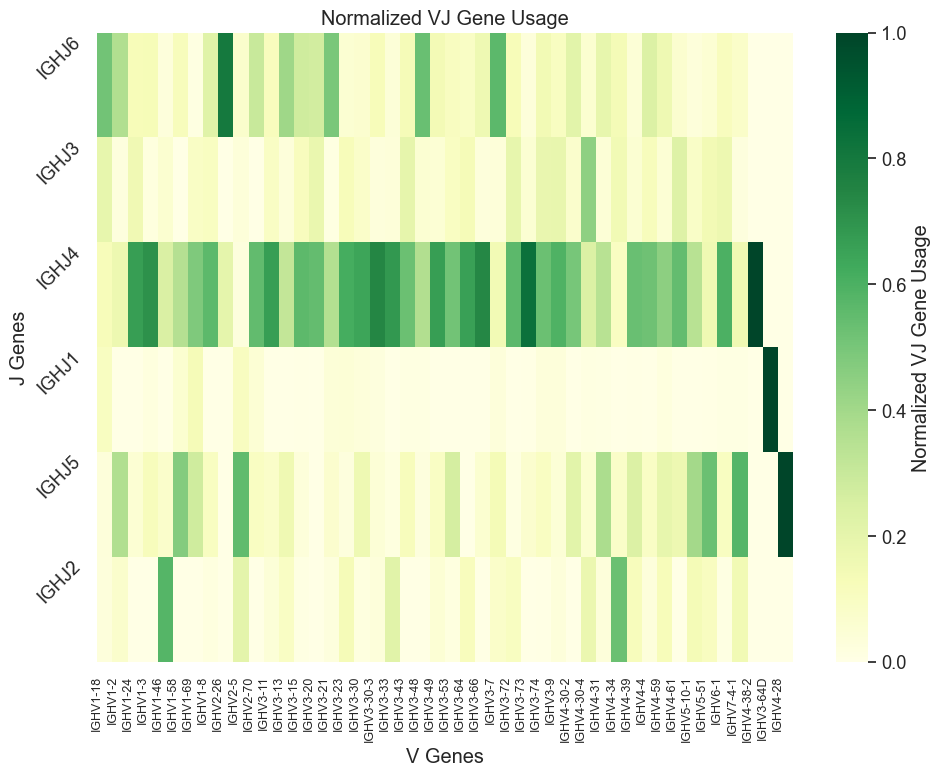

In [6]:
j_counts = dataframe.get_mature().groupby('v_call')['j_call'].apply(lambda x: (x.unique(), x.value_counts()))
v_genes = j_counts.index.to_list()
j_genes = j_counts.apply(lambda x: x[0]).to_list()
counts = j_counts.apply(lambda x: x[1].to_list()).to_list()

vj_gene_usage = {}
for i, v_gene in enumerate(v_genes):
    vj_gene_usage_dict = {isotype: count for isotype, count in zip(j_genes[i], counts[i])}
    vj_gene_usage[v_gene] = vj_gene_usage_dict

df = pd.DataFrame.from_dict(vj_gene_usage, orient='index').fillna(0)

df_normalized = df.div(df.sum(axis=1), axis=0)

plt.figure(figsize=(10, 8))
sns.set(font_scale = 1.2)
sns.heatmap(df_normalized.transpose(), annot=False, cmap='YlGn', cbar_kws={'label': 'Normalized VJ Gene Usage'})

plt.title('Normalized VJ Gene Usage')
plt.xlabel('V Genes')
plt.ylabel('J Genes', rotation=90)

ax = plt.gca()
ax.set_xticks(range(len(df.index)))
ax.set_xticklabels(df.index, fontsize = 9)

ax.set_yticks(range(len(df.columns)))
ax.set_yticklabels(df.columns, rotation=45, va='top')

plt.tight_layout()
plt.show()